## Creating the environement

In [1]:
import gymnasium as gym
import pygame
import numpy as np
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import time

In [2]:
class SimpleCorridor(gym.Env):
    def __init__(self, size=15):
        self.length = size
        self.start_pos = 0
        self.end_pos = self.length - 1
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(
            0.0, self.length, shape=(2,), dtype=int)
        self.mode = "rgb_array"
        self.width = 20

    def reset(self):
        self.current_pos = self.start_pos
        return np.array([self.current_pos, self.end_pos])

    def step(self, action):
        if action == 0 and self.current_pos > 0:
            self.current_pos -= 1
        if action == 1 and self.current_pos < self.length - 1:
            self.current_pos += 1
        done = self.current_pos == self.end_pos
        reward = 1 if done else -1
        info = {}
        return np.array([self.current_pos, self.end_pos]), reward, done, info

    def simulate_step(self, tpos, action):
        if action == 0 and tpos > 0:
            tpos -= 1
        if action == 1 and tpos < self.length -1:
            tpos += 1
            
        done = tpos == self.end_pos
        reward = 1 if done else -1
        info = {}
        return tpos, reward, done, info
        
    def render(self, mode="rgb_array"):
        canvas = pygame.Surface((self.width, self.width * self.length + 1))
        canvas.fill((255,255,255))
        for i in range(self.length+1):
            pygame.draw.line(canvas, 0, (0, 20*(i)), (20, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (0,0), (0, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (19,0), (19, 20*(i)), width=1)
        pygame.draw.circle(canvas, (0, 0, 255), (10,self.current_pos*20+10), 7)
        pygame.draw.circle(canvas, (255, 0, 0), (10,(self.end_pos)*20+10), 7)
        plArray = np.array(pygame.surfarray.pixels3d(canvas))
        plt.imshow(plArray)        
        plt.axis("off")


## Test Agent Function 

In [3]:
def test_agent(env: gym.Env, policy: callable, episodes: int = 10) -> None: 
    for episode in range(episodes):
        temp = env.reset()
        tagent_pos = temp[0]
        ttarget_pos = temp[1]
        done = False  
       
        env.render(mode="rgb_array")
        while not done:
            p = policy(tagent_pos)
            action = np.random.choice(2,p=p)

            next_state, _, done, _ = env.step(action)
            env.render()
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
            
            tagent_pos = next_state[0]

## Initialising the environment 

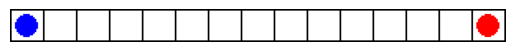

In [4]:
env = SimpleCorridor()
env.reset()
env.render()


### Creating the Policy

In [5]:
policy_probs = np.full((15,2) ,0.5)
print(policy_probs)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


In [6]:
def policy(state):
    return policy_probs[state]

## Value Table

In [7]:
state_values = np.zeros(shape=(15))
print(state_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Implementing the policy iteration algorithm 

In [8]:
def policy_evaluation(policy_probs, state_values, theta = 1e-6, gamma = 0.99):
    delta = float("inf")

    while delta > theta: 
        delta = 0
        for state in range(15):
            old_value = state_values[state]
            new_value = 0.
            action_probablities = policy_probs[state]

            for action, prob in enumerate(action_probablities):
                next_state, reward, _, _ = env.simulate_step(state, action)
                new_value += prob * (reward + gamma * state_values[next_state])

            state_values[state] = new_value
            delta = max(delta, abs(old_value - new_value))

In [9]:
def policy_improvement(policy_probs, state_values, gamma = 0.99):
    policy_stable = True

    for state in range(15):
        old_action = policy_probs[state].argmax()

        new_action = None
        max_qsa = float("-inf")

        for action in range(2):
            next_state, reward, _, _ = env.simulate_step(state, action)
            qsa = reward + gamma * state_values[next_state]

            if qsa > max_qsa: 
                new_action = action
                max_qsa = qsa

        action_probs = np.zeros(2)
        action_probs[new_action] = 1
        policy_probs[state] = action_probs

        if new_action != old_action: 
            policy_stable = False

    return policy_stable

In [10]:
def policy_iteration(policy_probs, state_values, theta = 1e-6, gamma = 0.99):
    policy_stable = False

    while not policy_stable: 
        policy_evaluation(policy_probs, state_values, theta, gamma)
        
        
        policy_stable = policy_improvement(policy_probs, state_values, gamma)

In [11]:
policy_iteration(policy_probs, state_values)

# Printing the final values

In [12]:
print(state_values)
print(policy_probs)

[75.5041056  77.27687534 79.06755185 80.876316   82.7033505  84.54883989
 86.41297058 88.29593088 90.19791098 92.119103   94.059701   96.019901
 97.999901   99.999901   99.999901  ]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Testing the resulting agent

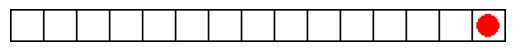

In [13]:
test_agent(env, policy)